In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

In [2]:
df = pd.read_csv("training_set.csv")
train = df.drop(['ARR_DELAY'], axis = 1)
y = df.ARR_DELAY
df.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,FL_NUM,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,ARR_DELAY
0,0,2,1020,11,8,373,"2,701",11,19930,2017-01-03,...,879,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,-11
1,1,6,1220,13,9,183,"1,171",5,19805,2017-01-28,...,2491,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,1
2,2,6,945,48,6,355,"2,552",11,19930,2017-01-21,...,172,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,18
3,3,1,1437,17,8,136,967,4,19977,2017-01-23,...,2030,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,0
4,4,1,830,37,7,114,534,3,19393,2017-01-02,...,3812,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,197


# Data Cleaning

In [5]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
train['CARRIER'] = le.fit_transform(train['UNIQUE_CARRIER'])
train['ORIG_STATE'] = le.fit_transform(train['ORIGIN_STATE_ABR'])

for i in range(len(train)):
    #print i
    train.loc[i, 'DISTANCE'] = train.loc[i, 'DISTANCE'].replace(',','')
    train.loc[i, 'DISTANCE'] = int(train.loc[i, 'DISTANCE'])
    
    date = train.loc[i, 'FL_DATE']
    train.loc[i, 'FL_DATE'] = datetime.datetime.strptime(date, '%Y-%m-%d')
    
    train.loc[i, 'DAY'] = train.loc[i, 'FL_DATE'].day
    train.loc[i, 'MONTH'] = train.loc[i, 'FL_DATE'].month
    
    if type( train.loc[i,'FIRST_DEP_TIME'] ) == float:
        train.loc[i, 'FIRST_DEP_TIME'] = np.nan
    else:
        train.loc[i, 'FIRST_DEP_TIME'] = train.loc[i, 'FIRST_DEP_TIME'].replace(',','')
        train.loc[i, 'FIRST_DEP_TIME'] = int(train.loc[i, 'FIRST_DEP_TIME'])


In [6]:
train

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,CARRIER,ORIG_STATE,DAY,MONTH
0,0,2,1020,11,8,373,2701,11,19930,2017-01-03 00:00:00,...,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,1,47,3.0,1.0
1,1,6,1220,13,9,183,1171,5,19805,2017-01-28 00:00:00,...,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,0,4,28.0,1.0
2,2,6,945,48,6,355,2552,11,19930,2017-01-21 00:00:00,...,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,1,0,21.0,1.0
3,3,1,1437,17,8,136,967,4,19977,2017-01-23 00:00:00,...,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,9,4,23.0,1.0
4,4,1,830,37,7,114,534,3,19393,2017-01-02 00:00:00,...,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,11,8,2.0,1.0
5,5,7,1735,28,5,151,984,4,20366,2017-01-01 00:00:00,...,"Houston, TX",TX,MKE,"Milwaukee, WI",WI,NaN,4,42,1.0,1.0
6,6,4,1240,11,6,46,160,1,20304,2017-01-05 00:00:00,...,"Yuma, AZ",AZ,PHX,"Phoenix, AZ",AZ,NaN,8,3,5.0,1.0
7,7,1,710,10,4,75,337,2,20416,2017-01-02 00:00:00,...,"Los Angeles, CA",CA,OAK,"Oakland, CA",CA,NaN,7,4,2.0,1.0
8,9,4,825,22,4,167,1250,6,20304,2017-01-05 00:00:00,...,"Salt Lake City, UT",UT,ORD,"Chicago, IL",IL,NaN,8,43,5.0,1.0
9,10,7,1632,43,6,162,852,4,20366,2017-01-15 00:00:00,...,"Dallas/Fort Worth, TX",TX,MSP,"Minneapolis, MN",MN,NaN,4,42,15.0,1.0


In [7]:
# Using Python's Dictionary as Hash-Map to to encode states as integers
# Using the same encoding for Destination State as well (for consistency)
states = {}

for i in range(len(train)):
    key = train.loc[i, 'ORIGIN_STATE_ABR']
    value = train.loc[i, 'ORIG_STATE']
    states[key] = value
    
for i in range(len(train)):
    val = train.loc[i, 'DEST_STATE_ABR']
    train.loc[i, 'DEST_STATE'] = states[val]

In [8]:
# Dropping the un-cleaned columns (ONLY FOR NOW !!!)
irrel_cols = ['ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'UNIQUE_CARRIER']
train = train.drop(irrel_cols, axis=1)

redundant_cols = ['FIRST_DEP_TIME', 'FL_DATE']
train = train.drop(redundant_cols, axis=1)

train.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,FL_NUM,CARRIER,ORIG_STATE,DAY,MONTH,DEST_STATE
0,0,2,1020,11,8,373,2701,11,19930,30559,32982,879,1,47,3.0,1.0,9.0
1,1,6,1220,13,9,183,1171,5,19805,33570,30194,2491,0,4,28.0,1.0,42.0
2,2,6,945,48,6,355,2552,11,19930,30299,30466,172,1,0,21.0,1.0,3.0
3,3,1,1437,17,8,136,967,4,19977,32457,30325,2030,9,4,23.0,1.0,5.0
4,4,1,830,37,7,114,534,3,19393,30397,30852,3812,11,8,2.0,1.0,44.0


In [12]:
train

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,FL_NUM,CARRIER,ORIG_STATE,DAY,MONTH,DEST_STATE
0,0,2,1020,11,8,373,2701,11,19930,30559,32982,879,1,47,3.0,1.0,9.0
1,1,6,1220,13,9,183,1171,5,19805,33570,30194,2491,0,4,28.0,1.0,42.0
2,2,6,945,48,6,355,2552,11,19930,30299,30466,172,1,0,21.0,1.0,3.0
3,3,1,1437,17,8,136,967,4,19977,32457,30325,2030,9,4,23.0,1.0,5.0
4,4,1,830,37,7,114,534,3,19393,30397,30852,3812,11,8,2.0,1.0,44.0
5,5,7,1735,28,5,151,984,4,20366,31453,33342,4220,4,42,1.0,1.0,48.0
6,6,4,1240,11,6,46,160,1,20304,33785,30466,3063,8,3,5.0,1.0,3.0
7,7,1,710,10,4,75,337,2,20416,32575,32457,949,7,4,2.0,1.0,4.0
8,9,4,825,22,4,167,1250,6,20304,34614,30977,5677,8,43,5.0,1.0,12.0
9,10,7,1632,43,6,162,852,4,20366,30194,31650,5153,4,42,15.0,1.0,21.0


In [10]:
cols = []
for col in train:
    cols.append(col)
    # Printing the data type of last element of every feature
    print col, "\t\t", type(train[col][len(train)-1])

UID 		<type 'numpy.int64'>
DAY_OF_WEEK 		<type 'numpy.int64'>
CRS_DEP_TIME 		<type 'numpy.int64'>
TAXI_OUT 		<type 'numpy.int64'>
TAXI_IN 		<type 'numpy.int64'>
ACTUAL_ELAPSED_TIME 		<type 'numpy.int64'>
DISTANCE 		<type 'int'>
DISTANCE_GROUP 		<type 'numpy.int64'>
AIRLINE_ID 		<type 'numpy.int64'>
ORIGIN_CITY_MARKET_ID 		<type 'numpy.int64'>
DEST_CITY_MARKET_ID 		<type 'numpy.int64'>
FL_NUM 		<type 'numpy.int64'>
CARRIER 		<type 'numpy.int64'>
ORIG_STATE 		<type 'numpy.int64'>
DAY 		<type 'numpy.float64'>
MONTH 		<type 'numpy.float64'>
DEST_STATE 		<type 'numpy.float64'>


In [11]:
# Inspecting non-NaN values in one of the columns

non_nan = [752, 904, 1940, 1813, 654, 1253, 2204, 743, 1103, 1400, 1601,
           1546, 606, 1354, 558, 1749, 1652, 754, 1839, 2341, 1827, 716, 
           1333, 1409, 839, 1002, 608, 1025, 1136]

inspect = []

for i in range(len(train)):
    for j in range(len(non_nan)):
        if train.FIRST_DEP_TIME[i] == non_nan[j]:
            inspect.append([non_nan[j], df.ARR_DELAY[i]])
            
inspect = pd.DataFrame(inspect)

y_axis = inspect[0]
x_axis = inspect[1]

plt.scatter(x_axis, y_axis)
plt.xlabel("FIRST_DEP_TIME")
plt.ylabel("ARR_DELAY")

AttributeError: 'DataFrame' object has no attribute 'FIRST_DEP_TIME'

# Data Distribution

### Box-Plot

Outliers: 350


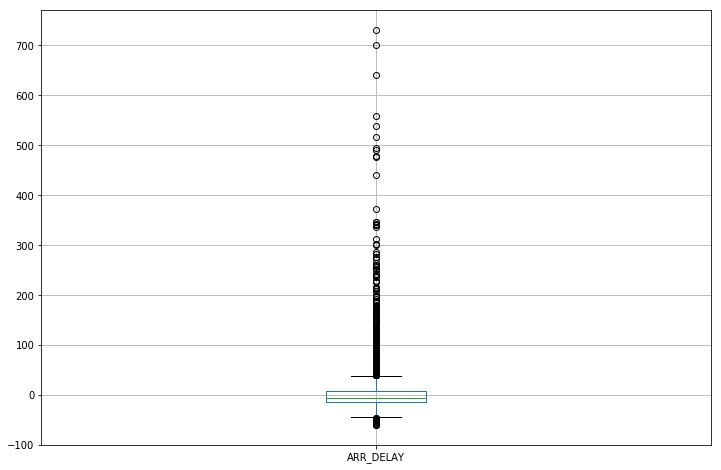

In [13]:
# Distribution of 'Arrival Delay'
plt.figure(figsize = (12, 8))
df.boxplot(column=['ARR_DELAY']) 

count = 0
for i in range(len(df)):
    if df.ARR_DELAY[i] > 50:
        count += 1
        
print "Outliers:", count

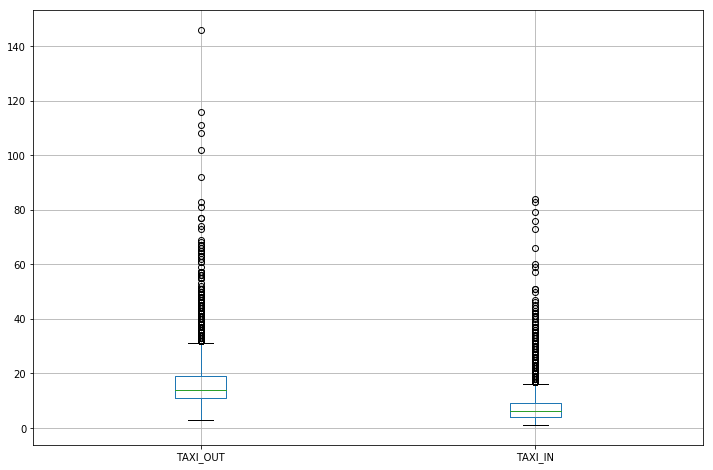

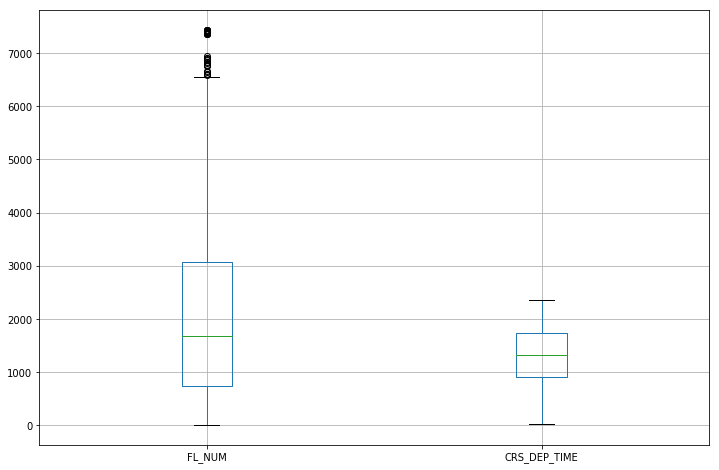

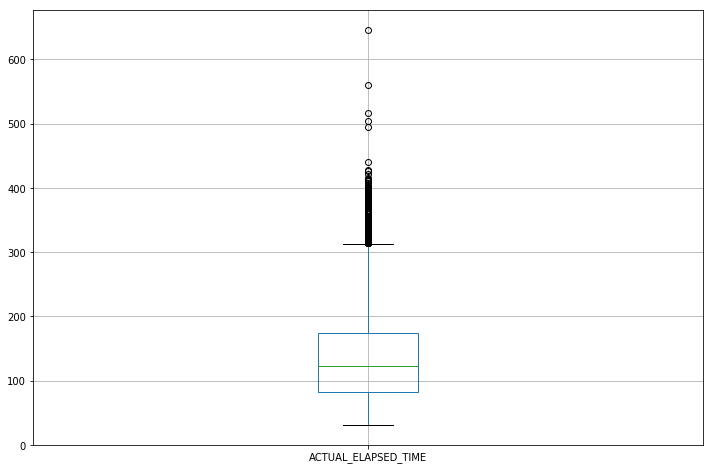

In [14]:
ax1 = plt.figure(figsize = (12, 8))
ax1 = train.boxplot(column=['TAXI_OUT', 'TAXI_IN']) 

ax2 = plt.figure(figsize = (12, 8))
ax2 = train.boxplot(column=['FL_NUM', 'CRS_DEP_TIME']) 

ax3 = plt.figure(figsize = (12, 8))
ax3 = train.boxplot(column=['ACTUAL_ELAPSED_TIME']) 

### Scatter-Plot

DAY_OF_WEEK


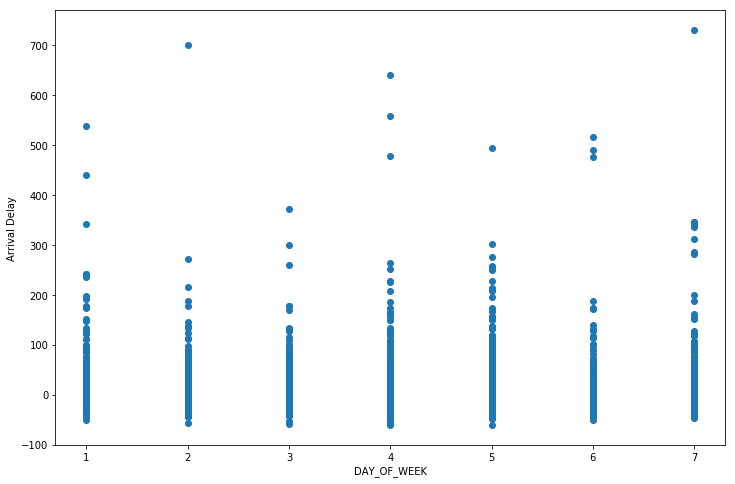

CRS_DEP_TIME


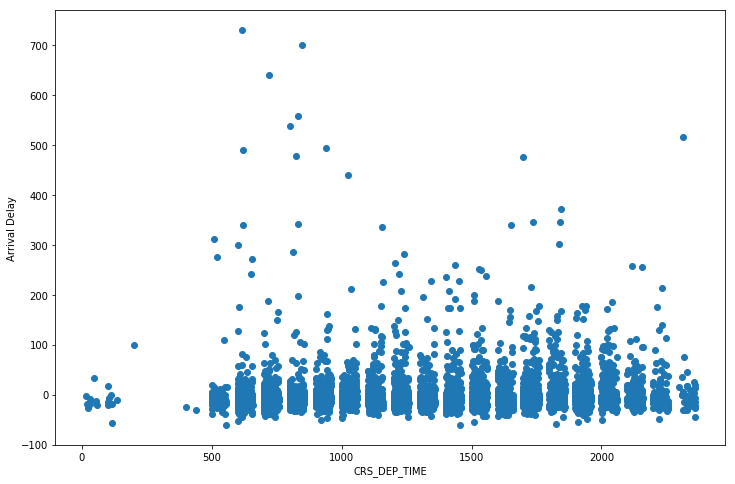

TAXI_OUT


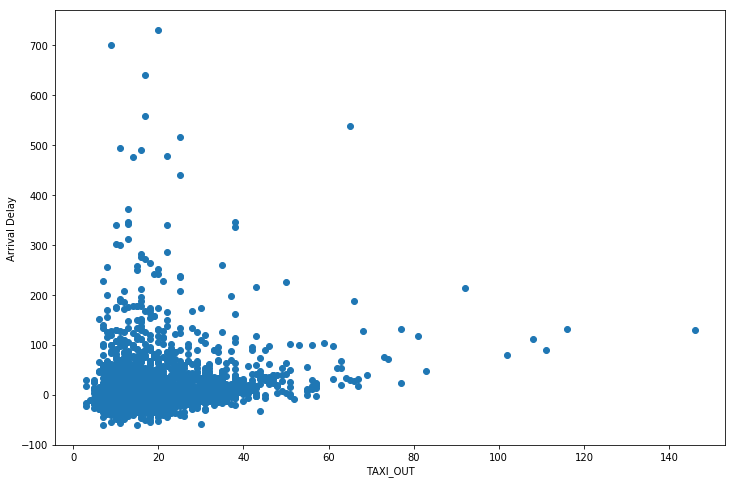

TAXI_IN


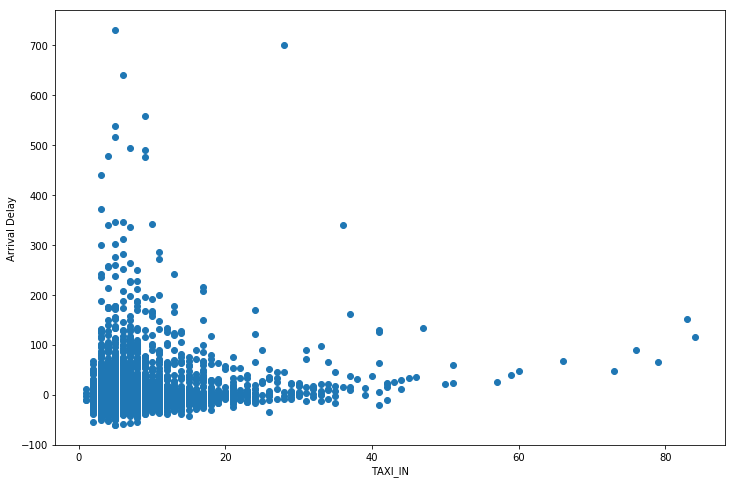

ACTUAL_ELAPSED_TIME


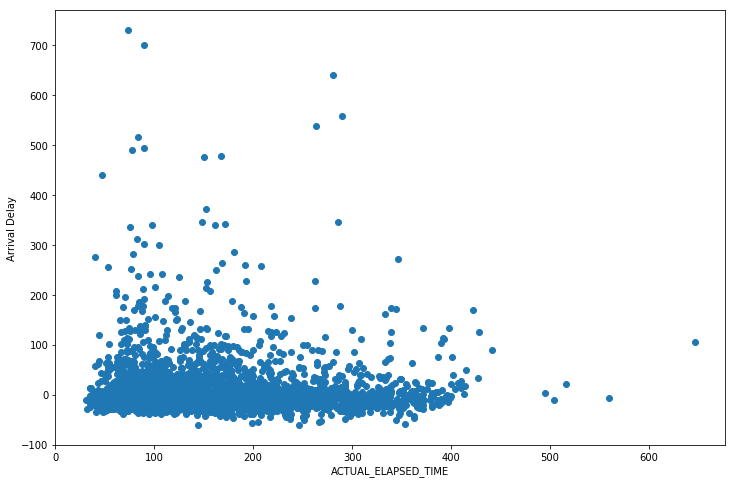

DISTANCE_GROUP


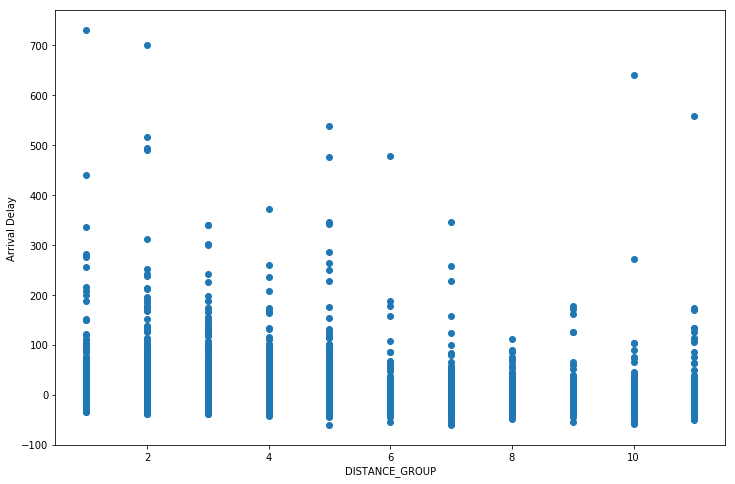

In [15]:
cols = ['DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE_GROUP']
for col in cols:
    print col
    feat = train[col]
    try:
        plt.figure(figsize = (12, 8))
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

UID


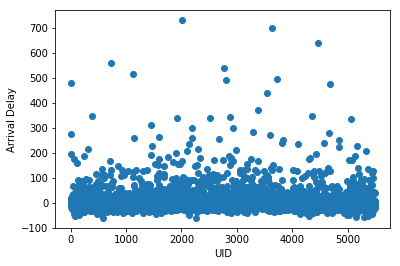

DAY_OF_WEEK


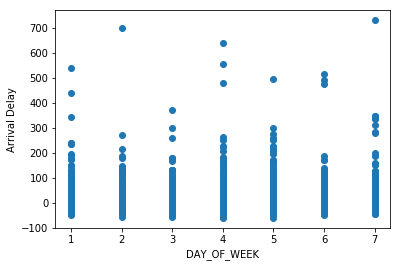

CRS_DEP_TIME


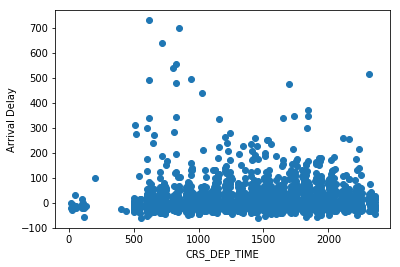

TAXI_OUT


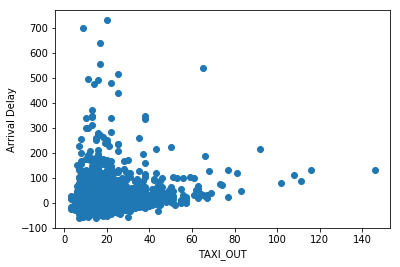

TAXI_IN


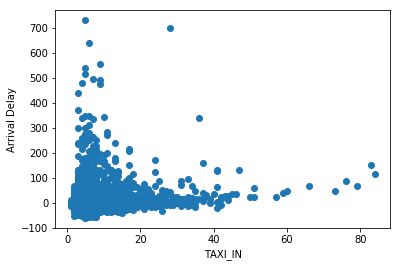

ACTUAL_ELAPSED_TIME


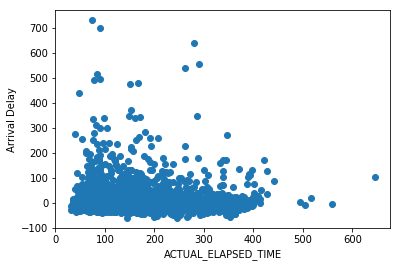

DISTANCE


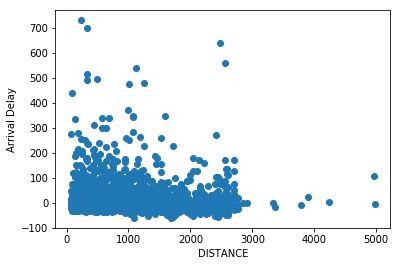

DISTANCE_GROUP


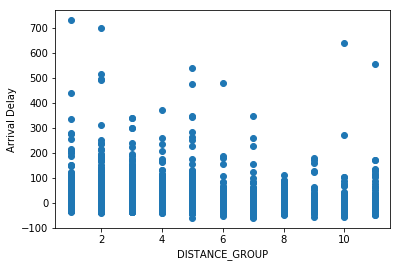

AIRLINE_ID


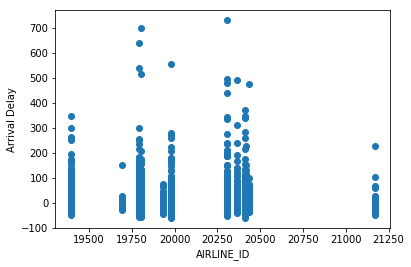

ORIGIN_CITY_MARKET_ID


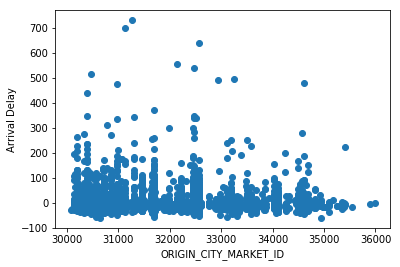

DEST_CITY_MARKET_ID


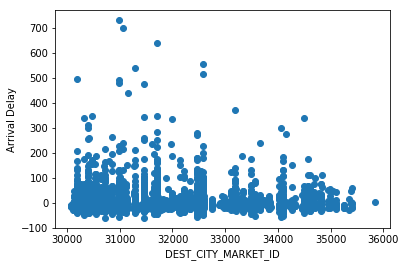

FL_NUM


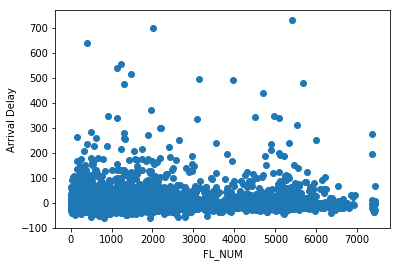

CARRIER


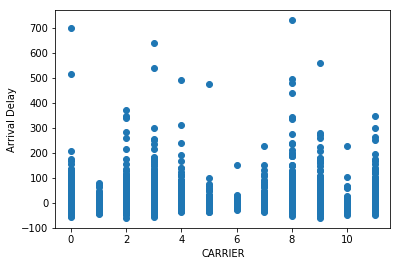

ORIG_STATE


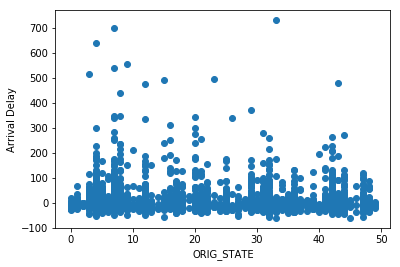

DAY


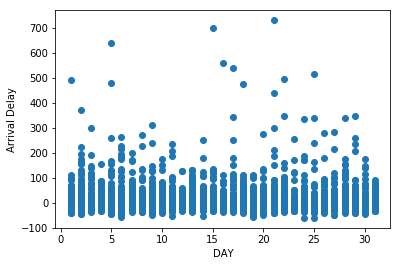

MONTH


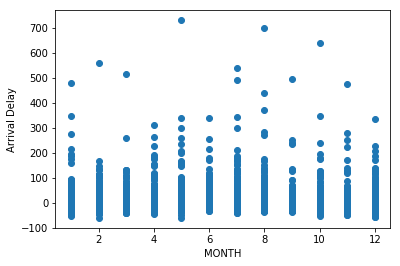

DEST_STATE


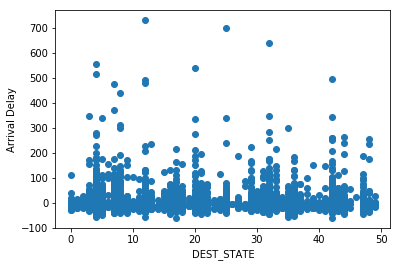

In [16]:
for col in train:
    print col
    feat = train[col]
    try:
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

In [43]:
df.describe()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,FL_NUM,ARR_DELAY
count,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000,4897.000000
mean,2761.054319,4.035736,1335.091280,16.565857,7.629569,142.914233,3.906882,19895.923014,31702.394936,31758.066163,2126.835205,3.683684
std,1582.254661,2.016615,483.863788,9.306015,5.766140,80.412295,2.522511,377.068177,1261.266618,1297.477377,1728.007428,41.856945
min,0.000000,1.000000,35.000000,4.000000,1.000000,21.000000,1.000000,19393.000000,30073.000000,30107.000000,1.000000,-59.000000
25%,1406.000000,2.000000,917.000000,11.000000,4.000000,84.000000,2.000000,19790.000000,30615.000000,30647.000000,734.000000,-15.000000
50%,2771.000000,4.000000,1330.000000,14.000000,6.000000,122.000000,3.000000,19805.000000,31453.000000,31454.000000,1700.000000,-6.000000
75%,4125.000000,6.000000,1735.000000,19.000000,9.000000,177.000000,5.000000,20304.000000,32467.000000,32575.000000,2978.000000,7.000000
max,5495.000000,7.000000,2355.000000,123.000000,116.000000,681.000000,11.000000,21171.000000,35841.000000,35412.000000,7437.000000,965.000000


# Predictive Modelling

### Cross-validation split

In [17]:
#x = np.array(train.drop(['UID', 'AIRLINE_ID', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'month'], axis = 1))
x = np.array(train)
y = np.array(y)

#irrelev_feat = ['UID']

# 20% split to test set as it will be used in the very end
x_train, x_test, y_train, y_test = np.array(train_test_split(x, y, train_size = 0.7))

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 1. Predicting from the mean

In [247]:
len(x_test)

1474

In [241]:
y_train = np.array(y_train)
mean = y_train.mean()
preds = []

for i in range(len(y_test)):
    preds.append(mean)
    
print "Mean Squared Error:", mse(y_test, preds)

Mean Squared Error: 2024.14339454


## 2. Decision Tree

### Cross-Validation

In [251]:
from sklearn.tree import DecisionTreeRegressor

leaves = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000]
for i in leaves:
    print "Leaf:", i
    
    DT_model = DecisionTreeRegressor(min_samples_leaf=i)
    DT_model.fit(x_train, y_train)
    
    preds_train = DT_model.predict(x_train)
    print "\tTraining Error (MSE):", mse(y_train, preds_train)
    
    preds_test = DT_model.predict(x_test)
    print "\tValidation Error (MSE):", mse(y_test, preds_test)
    
    R_squared_train = DT_model.score(x_train, y_train)
    print "\tTraining Error (R^2):", R_squared_train
    
    R_squared_test = DT_model.score(x_test, y_test)
    print "\tValidation Error (R^2):", R_squared_test

Leaf: 1
	Training Error (MSE): 0.0
	Validation Error (MSE): 1485.46507353
	Training Error (R^2): 1.0
	Validation Error (R^2): 0.225550422018
Leaf: 2
	Training Error (MSE): 170.329811128
	Validation Error (MSE): 1608.78446691
	Training Error (R^2): 0.897908833843
	Validation Error (R^2): 0.1612576602
Leaf: 3
	Training Error (MSE): 444.350627871
	Validation Error (MSE): 1684.04069564
	Training Error (R^2): 0.733668032146
	Validation Error (R^2): 0.122022705697
Leaf: 5
	Training Error (MSE): 705.646940616
	Validation Error (MSE): 1793.93016006
	Training Error (R^2): 0.577053960281
	Validation Error (R^2): 0.0647316586932
Leaf: 7
	Training Error (MSE): 826.483687705
	Validation Error (MSE): 1666.4330103
	Training Error (R^2): 0.504627622559
	Validation Error (R^2): 0.131202500443
Leaf: 10
	Training Error (MSE): 950.811204014
	Validation Error (MSE): 1753.58338593
	Training Error (R^2): 0.430109010454
	Validation Error (R^2): 0.0857665135381
Leaf: 15
	Training Error (MSE): 1106.36470468
	Va

### K-Fold Cross Validation Error (with shuffling)

In [18]:
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor

MSE_stats = pd.DataFrame()
R2_stats = pd.DataFrame()
  
leaves = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000]

train_set = np.copy(train)

for j in range(0, 10):
    
    MSE_list = []
    R2_list = []
    
    kf=KFold(len(train), n_folds=3, shuffle=True) 
    
    for t, t2 in kf:
        x_train = [train_set[ii] for ii in t]
        y_train = [y[ii] for ii in t]
        x_test = [train_set[ii] for ii in t2]
        y_test = [y[ii] for ii in t2]

    for i in leaves:
        DT_model = DecisionTreeRegressor(min_samples_leaf=i)
        DT_model.fit(x_train, y_train)
        preds = DT_model.predict(x_test)
        MSE = mse(y_test, preds)
        MSE_list.append(MSE)
        
        R_squared = DT_model.score(x_test, y_test)
        R2_list.append(R_squared)
    
    MSE_stats[j] = MSE_list
    R2_stats[j] = R2_list
    
kfold_mean_MSE = {}
kfold_mean_R2 = {}

for i in range(len(leaves)):
    print "Leaf:", leaves[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]
    
    kfold_mean_R2[i] = R2_stats.loc[i].mean()
    print "\tR2 value:", kfold_mean_R2[i]

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Leaf: 1
	MSE: 4313.29260843
	R2 value: -1.32967391401
Leaf: 2
	MSE: 3352.40554368
	R2 value: -0.812641936809
Leaf: 3
	MSE: 2923.81634368
	R2 value: -0.58036800948
Leaf: 5
	MSE: 2538.19670067
	R2 value: -0.367654449599
Leaf: 7
	MSE: 2297.83183773
	R2 value: -0.237058350897
Leaf: 10
	MSE: 2180.2185278
	R2 value: -0.168674791009
Leaf: 15
	MSE: 2041.5526281
	R2 value: -0.0937636174692
Leaf: 20
	MSE: 2014.19792592
	R2 value: -0.0797585324926
Leaf: 30
	MSE: 1925.86777711
	R2 value: -0.0318757967817
Leaf: 40
	MSE: 1908.40549504
	R2 value: -0.0218975351257
Leaf: 50
	MSE: 1881.38231175
	R2 value: -0.00765049817853
Leaf: 70
	MSE: 1849.25469046
	R2 value: 0.010350415174
Leaf: 100
	MSE: 1830.68280209
	R2 value: 0.0212528020936
Leaf: 200
	MSE: 1822.68633156
	R2 value: 0.0263925249705
Leaf: 500
	MSE: 1822.06993021
	R2 value: 0.0267728389387
Leaf: 1000
	MSE: 1841.26932188
	R2 value: 0.0161744275473
Leaf: 2000
	MSE: 1873.07665592
	R2 value: -0.00103201599771
Leaf: 3000
	MSE: 1873.07665592
	R2 value: -

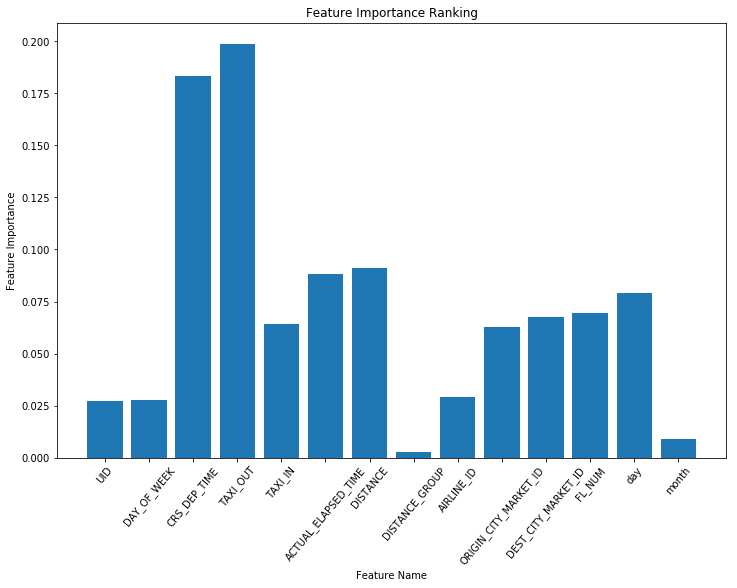

In [97]:
from sklearn.tree import DecisionTreeRegressor

DT_model = DecisionTreeRegressor(min_samples_leaf=2)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

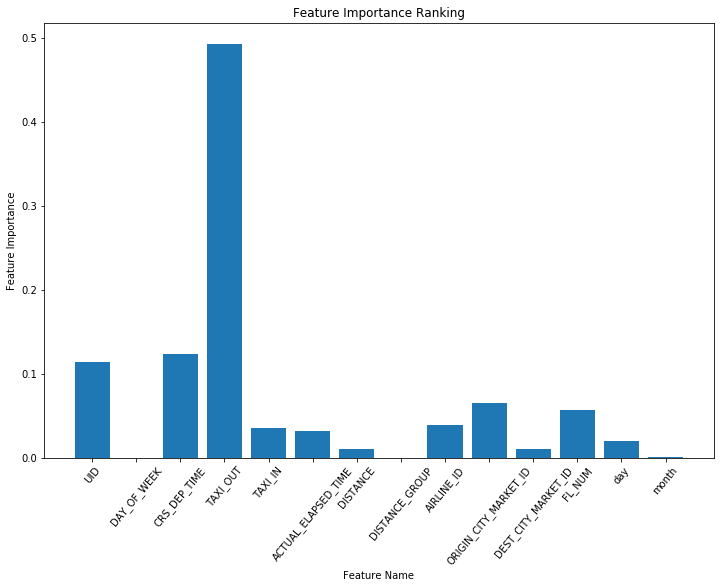

In [98]:
DT_model = DecisionTreeRegressor(min_samples_leaf=20)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

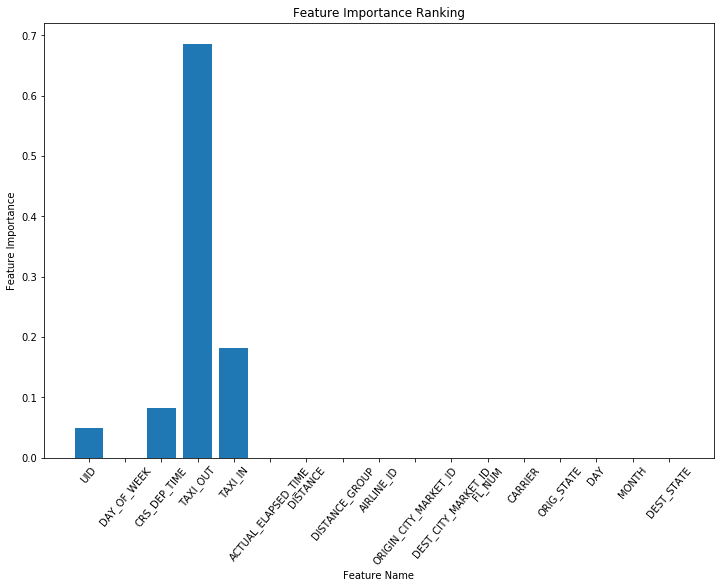

In [239]:
DT_model = DecisionTreeRegressor(min_samples_leaf=500)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

### Less Features

In [106]:
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor

MSE_stats = pd.DataFrame()
R2_stats = pd.DataFrame()
  
leaves = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000]

train_set = np.array(train.drop(['UID', 'AIRLINE_ID', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'month'], axis = 1))

for j in range(0, 10):
    
    MSE_list = []
    R2_list = []
    
    kf=KFold(len(train), n_folds=3, shuffle=True) 
    
    for t, t2 in kf:
        x_train = [train_set[ii] for ii in t]
        y_train = [y[ii] for ii in t]
        x_test = [train_set[ii] for ii in t2]
        y_test = [y[ii] for ii in t2]

    for i in leaves:
        DT_model = DecisionTreeRegressor(min_samples_leaf=i)
        DT_model.fit(x_train, y_train)
        preds = DT_model.predict(x_test)
        MSE = mse(y_test, preds)
        MSE_list.append(MSE)
        
        R_squared = DT_model.score(x_test, y_test)
        R2_list.append(R_squared)
    
    MSE_stats[j] = MSE_list
    R2_stats[j] = R2_list
    
kfold_mean_MSE = {}
kfold_mean_R2 = {}

for i in range(len(leaves)):
    print "Leaf:", leaves[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]
    
    kfold_mean_R2[i] = R2_stats.loc[i].mean()
    print "\tR2 value:", kfold_mean_R2[i]

Leaf: 1
	MSE: 4623.14618204
	R2 value: -1.42223505558
Leaf: 2
	MSE: 3550.08811003
	R2 value: -0.840027080246
Leaf: 3
	MSE: 3059.50054851
	R2 value: -0.58289429341
Leaf: 5
	MSE: 2588.02625905
	R2 value: -0.334497485747
Leaf: 7
	MSE: 2426.81889502
	R2 value: -0.247306204219
Leaf: 10
	MSE: 2254.02193363
	R2 value: -0.155583905641
Leaf: 15
	MSE: 2135.73663829
	R2 value: -0.0950005956034
Leaf: 20
	MSE: 2070.60833839
	R2 value: -0.0609196990702
Leaf: 30
	MSE: 2020.80845729
	R2 value: -0.0337624869366
Leaf: 40
	MSE: 1978.03521648
	R2 value: -0.0123127355934
Leaf: 50
	MSE: 1970.58976198
	R2 value: -0.00818040572159
Leaf: 70
	MSE: 1944.71206793
	R2 value: 0.00467853725192
Leaf: 100
	MSE: 1924.03012946
	R2 value: 0.0157367359277
Leaf: 200
	MSE: 1905.96162587
	R2 value: 0.0258464797059
Leaf: 500
	MSE: 1908.83090408
	R2 value: 0.0242603033723
Leaf: 1000
	MSE: 1920.94901371
	R2 value: 0.017751207161
Leaf: 2000
	MSE: 1956.87891392
	R2 value: -0.000826313823085
Leaf: 3000
	MSE: 1956.87891392
	R2 valu

# Linear Regression

In [165]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)
print "MSE:", mse(y_test, preds)
print "MAE:", mae(y_test, preds)

MSE: 1600.97313818
MAE: 20.9775644971


### Less features

In [44]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)
print i, "MSE:", mse(y_test, preds)
R_squared = LR_model.score(x_test, y_test)
#R2.append([R_squared, i])
print i, "R^2 value:", R_squared

100000 MSE: 1647.95193178
100000 R^2 value: 0.0761479466118


# K-Nearest Neighbors

In [166]:
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor()
KNN_model.fit(x_train, y_train)
preds = KNN_model.predict(x_test)
print "MSE:", mse(y_test, preds)
print "MAE:", mae(y_test, preds)

MSE: 1952.48855539
MAE: 24.6099030117


### Less Features

In [51]:
from sklearn.neighbors import KNeighborsRegressor

neighbors = [1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 70, 100, 200, 300, 500, 700]

for i in neighbors:    
    KNN_model = KNeighborsRegressor(n_neighbors=i)
    KNN_model.fit(x_train, y_train)
    preds = KNN_model.predict(x_test)
    print i, "MSE:", mse(y_test, preds)
    R_squared = KNN_model.score(x_test, y_test)
    #R2.append([R_squared, i])
    print i, "R^2 value:", R_squared

1 MSE: 2439.79913221
1 R^2 value: -0.367766495294
2 MSE: 2256.54134763
2 R^2 value: -0.265031046934
3 MSE: 2172.93914129
3 R^2 value: -0.218163132581
5 MSE: 2037.12866769
5 R^2 value: -0.142026940448
8 MSE: 1916.9735356
8 R^2 value: -0.0746672296708
10 MSE: 1895.35255232
10 R^2 value: -0.062546372614
15 MSE: 1853.58756962
15 R^2 value: -0.0391326647966
20 MSE: 1835.73521184
20 R^2 value: -0.0291245225238
30 MSE: 1799.73593415
30 R^2 value: -0.00894310462234
50 MSE: 1788.51057295
50 R^2 value: -0.00265009764867
70 MSE: 1779.68174001
70 R^2 value: 0.00229940074504
100 MSE: 1775.01229117
100 R^2 value: 0.00491712266635
200 MSE: 1768.64964993
200 R^2 value: 0.00848405872825
300 MSE: 1772.86750856
300 R^2 value: 0.00611950107013
500 MSE: 1777.74024251
500 R^2 value: 0.00338781626122
700 MSE: 1782.55798141
700 R^2 value: 0.000686962011645


# Support Vector Machines

In [180]:
from sklearn.svm import SVR as SVM

SVM_model = SVM()
SVM_model.fit(x_train, y_train)
preds = SVM_model.predict(x_test)
print "MSE:", mse(y_test, preds)
print "MAE:", mae(y_test, preds)

MSE: 1902.75495598
MAE: 19.8121562168


### Less features

In [52]:
from sklearn.svm import SVR as SVM

SVM_model = SVM()
SVM_model.fit(x_train, y_train)
preds = SVM_model.predict(x_test)
print i, "MSE:", mse(y_test, preds)
R_squared = SVM_model.score(x_test, y_test)
#R2.append([R_squared, i])
print i, "R^2 value:", R_squared

700 MSE: 1877.18701074
700 R^2 value: -0.0523626575635


# Random Forests

In [54]:
from sklearn.ensemble import RandomForestRegressor

trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500, 700, 1000, 2000]
for i in trees:
    RF_model = RandomForestRegressor(n_estimators=i)
    RF_model.fit(x_train, y_train)
    preds = RF_model.predict(x_test)
    print i, "MSE:", mse(y_test, preds)
    R_squared = RF_model.score(x_test, y_test)
    #R2.append([R_squared, i])
    print i, "R^2 value:", R_squared

5 MSE: 1776.22795304
5 R^2 value: 0.00423561509832
10 MSE: 1542.91437979
10 R^2 value: 0.135032648419
20 MSE: 1543.12219819
20 R^2 value: 0.134916144136
30 MSE: 1494.31322897
30 R^2 value: 0.162278754395
50 MSE: 1488.98705391
50 R^2 value: 0.165264641105
70 MSE: 1474.13078497
70 R^2 value: 0.173593157427
80 MSE: 1464.22762231
80 R^2 value: 0.179144931711
100 MSE: 1468.3396734
100 R^2 value: 0.176839690416
200 MSE: 1477.11727087
200 R^2 value: 0.171918914948
500 MSE: 1458.83158518
500 R^2 value: 0.182169983528
700 MSE: 1461.13143877
700 R^2 value: 0.180880671369
1000 MSE: 1457.59070484
1000 R^2 value: 0.182865628725
2000 MSE: 1461.11152666
2000 R^2 value: 0.18089183422


### Less Features

In [245]:
from sklearn.ensemble import RandomForestRegressor

trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500, 700, 1000, 2000]
for i in trees:
    RF_model = RandomForestRegressor(n_estimators=i)
    RF_model.fit(x_train, y_train)
    
    preds_train = RF_model.predict(x_train)
    print i, "Training MSE:", mse(y_train, preds_train)    
    
    preds_test = RF_model.predict(x_test)
    print i, "Testing MSE:", mse(y_test, preds_test)
    R_squared = RF_model.score(x_test, y_test)
    #R2.append([R_squared, i])
    print i, "R^2 value:", R_squared

5 Training MSE: 587.149898167
5 Testing MSE: 2450.64629579
5 R^2 value: -0.210993789801
10 Training MSE: 448.519071865
10 Testing MSE: 2311.19717775
10 R^2 value: -0.142084614195
20 Training MSE: 362.384228251
20 Testing MSE: 2134.08387551
20 R^2 value: -0.0545635755728
30 Training MSE: 338.353672777
30 Testing MSE: 2038.95371702
30 R^2 value: -0.00755473902654
50 Training MSE: 324.591044748
50 Testing MSE: 2063.62005617
50 R^2 value: -0.0197436801978
70 Training MSE: 296.624484214
70 Testing MSE: 2082.69546908
70 R^2 value: -0.0291698493724
80 Training MSE: 299.93654868
80 Testing MSE: 2094.91752968
80 R^2 value: -0.0352094151426
100 Training MSE: 317.129987315
100 Testing MSE: 2072.98000142
100 R^2 value: -0.0243689235842
200 Training MSE: 306.531465697
200 Testing MSE: 2032.651494
200 R^2 value: -0.00444047771582
500 Training MSE: 287.922813978
500 Testing MSE: 2040.90766979
500 R^2 value: -0.00852029030886
700 Training MSE: 286.124219336
700 Testing MSE: 2028.46338733
700 R^2 value

In [243]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor

MSE_stats = pd.DataFrame()
R2_stats = pd.DataFrame()
  
trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500, 700, 1000, 2000]

train_set = np.copy(train)

for j in range(0, 10):
    
    MSE_list = []
    R2_list = []
    
    kf=KFold(len(train), n_folds=3, shuffle=True) 
    
    for t, t2 in kf:
        x_train = [train_set[ii] for ii in t]
        y_train = [y[ii] for ii in t]
        x_test = [train_set[ii] for ii in t2]
        y_test = [y[ii] for ii in t2]

    for i in trees:
        RF_model = RandomForestRegressor(n_estimators=i)
        RF_model.fit(x_train, y_train)
        preds = RF_model.predict(x_test)
        MSE = mse(y_test, preds)
        MSE_list.append(MSE)
        
        R_squared = RF_model.score(x_test, y_test)
        R2_list.append(R_squared)
    
    MSE_stats[j] = MSE_list
    R2_stats[j] = R2_list
    
kfold_mean_MSE = {}
kfold_mean_R2 = {}

for i in range(len(leaves)):
    print "Leaf:", leaves[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]
    
    kfold_mean_R2[i] = R2_stats.loc[i].mean()
    print "\tR2 value:", kfold_mean_R2[i]

KeyboardInterrupt: 